In [164]:
from ipypb import track as tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import itertools
import numba
import random
import diffplan
import astar
import envs
import prior_envs
import heapq
import joblib
import copy
from IPython.display import display
%load_ext autoreload
%autoreload 2
%matplotlib inline

eps = torch.finfo().eps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
loaded = {}
def _load(fn):
    if fn in loaded:
        return loaded[fn]
    loaded[fn] = joblib.load(fn)
    return loaded[fn]

# Visualizing f2c

In [263]:
figsize = 3

def visualize_enum(env):
    D = diffplan.compute_distance_matrix(env)
    BFS = diffplan.compute_bfs_matrix(env, D)
    d=diffplan.option_learner_enum(env, search_cost=D+BFS, num_options=1)

    logit_option = torch.zeros(len(env.states))
    for row in d:
        assert len(row['options']) == 1
        logit_option[row['options'][0]] = row['value']
    return diffplan.plot_graph(env, z=logit_option.softmax(0), size=figsize)

In [264]:
def compute_cost(env, terminations):
    env = copy.copy(env)
    d = diffplan.compute_distance_matrix(env)
    bfs = diffplan.compute_bfs_matrix(env, d)
    sc = d+bfs
    csum = 0
    env.start_states = env.states
    for g in env.states_features:
        env.goal_set={g}
        gterm = torch.zeros((1, len(env.states)))
        gterm[0, env.states_to_idx[g]] = 100.
        terms = torch.cat([terminations, gterm], axis=0)
        res = diffplan.option_planner_bfs_vec(env, terms, sc)
        csum += res[0].item()
    return csum/len(env.states_features)

def visualize_result_mean(env, results, best=False, value_weighted=False):
    num_options = results['results'][0]['terminations'].shape[0]
    if best:
        for r in results['results']:
            if 'cost' not in r:
                assert len(r['terminations'].shape) == 2, r['terminations'].shape
                r['cost'] = compute_cost(env, r['terminations'])
        r = min(results['results'], key=lambda r: r['cost'])
        terms = r['terminations'].softmax(1).numpy().mean(0)
    else:
        all_terms = np.array([
            r['terminations'].softmax(1).numpy()
            for r in results['results']
        ])
        if value_weighted:
            terms = (-costs).softmax(0) @ torch.tensor(all_terms.mean(1))
        else:
            terms = all_terms.mean(0).mean(0)
    return diffplan.plot_graph(env, z=terms*num_options, size=figsize)#, vmin=0, vmax=1)

{'options': (5,), 'value': -6.453541231155396}
{'options': (4,), 'value': -6.453541707992554}
{'options': (8,), 'value': -6.468213415145874}


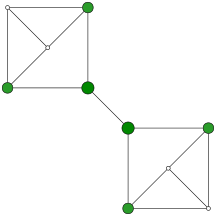

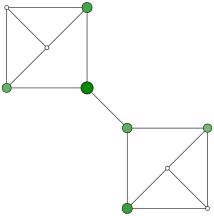

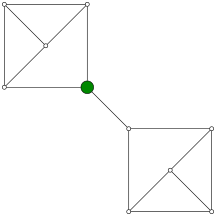

In [284]:
results = _load('../f2c-o1.bin')
display(visualize_enum(prior_envs.f2c))
display(visualize_result_mean(prior_envs.f2c, results))
display(visualize_result_mean(prior_envs.f2c, results, best=True))

{'options': (9,), 'value': -11.837311343142861}
{'options': (16,), 'value': -11.905988617947227}
{'options': (2,), 'value': -11.905988768527383}


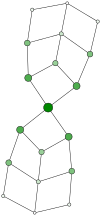

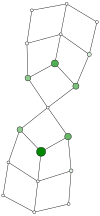

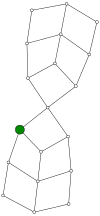

In [282]:
results = _load('../f2d-o1.bin')
display(visualize_enum(prior_envs.f2d))
display(visualize_result_mean(prior_envs.f2d, results))
display(visualize_result_mean(prior_envs.f2d, results, best=True))

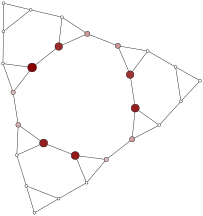

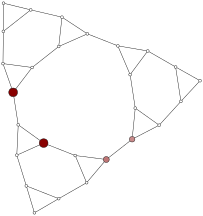

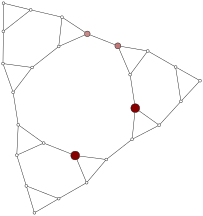

In [283]:
results = _load('../f2f-o3.bin')
display(visualize_result_mean(prior_envs.f2f, results))
display(visualize_result_mean(prior_envs.f2f, results, best=True))
display(visualize_result_mean(prior_envs.f2f, results, value_weighted=True))

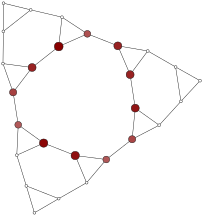

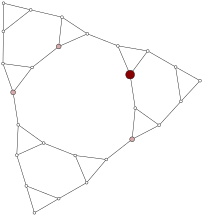

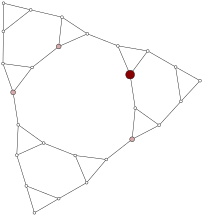

In [268]:
results = _load('../f2f-o6.bin')
display(visualize_result_mean(prior_envs.f2f, results))
display(visualize_result_mean(prior_envs.f2f, results, best=True))
display(visualize_result_mean(prior_envs.f2f, results, value_weighted=True))

# bonus

{'options': (23,), 'value': -16.453394501297563}
{'options': (20,), 'value': -16.453394607261377}
{'options': (4,), 'value': -16.453394642582648}


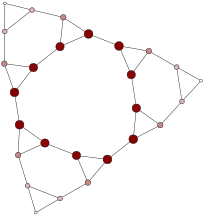

In [272]:
display(visualize_enum(prior_envs.f2f))

{'options': (8,), 'value': -8.74465503692627}
{'options': (9,), 'value': -8.744655164082845}
{'options': (13,), 'value': -8.744655164082845}


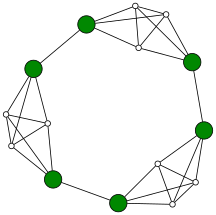

In [270]:
display(visualize_enum(prior_envs.f2a))